In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install emoji

In [3]:
import pandas as pd
import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import emoji
from tqdm.notebook import tqdm
import warnings
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
import transformers
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import accuracy_score,matthews_corrcoef
import tensorflow as tf
from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)

# Ignore warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# loading dataset 
df = pd.read_csv("/kaggle/input/movie-reviews/movie_review.csv")
df.head()

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


In [5]:
df.describe()

,fold_id,html_id,sent_id
count,64720.0000,64720.0000,64720.0000
mean,4.5494,16074.0974,18.9812
std,2.8532,7175.2825,15.0837
min,0.0000,42.0000,0.0000
25%,2.0000,10613.0000,8.0000
50%,5.0000,15091.0000,16.0000
75%,7.0000,21865.0000,27.0000
max,9.0000,29867.0000,111.0000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64720 entries, 0 to 64719
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   fold_id  64720 non-null  int64 
 1   cv_tag   64720 non-null  object
 2   html_id  64720 non-null  int64 
 3   sent_id  64720 non-null  int64 
 4   text     64720 non-null  object
 5   tag      64720 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.0+ MB


## EXPLORATORY DATA ANALYSIS

In [7]:
count1 = df['tag'].value_counts()
count1
df['cv_tag'].value_counts()

cv256    166
cv501    153
cv122    145
cv638    144
cv623    143
        ... 
cv825     25
cv329     25
cv515     25
cv114     24
cv058     23
Name: cv_tag, Length: 1000, dtype: int64

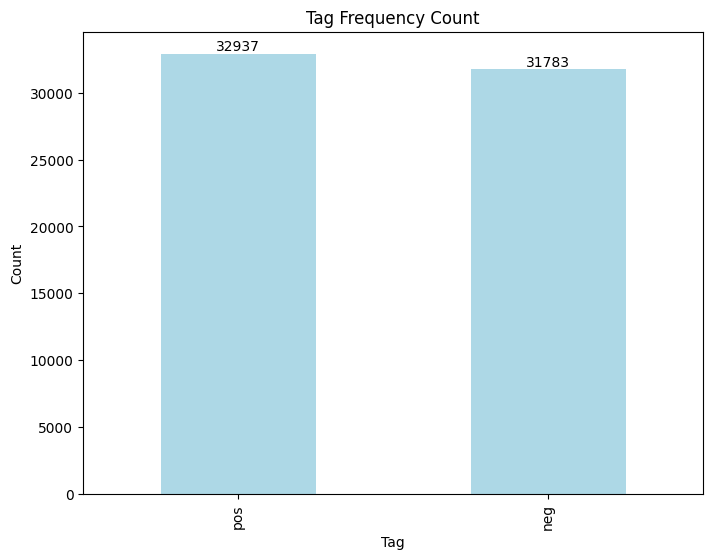

In [8]:
# count the frequency of each sentiment label
tag_count = df.tag.value_counts()

# create a column plot
fig, ax = plt.subplots(figsize=(8,6))
tag_count.plot(kind='bar', ax=ax, color = 'lightblue')

# set the plot title and axis labels
ax.set_title('Tag Frequency Count')
ax.set_xlabel('Tag')
ax.set_ylabel('Count')

# add data labels to the top of each column
for i, freq in enumerate(tag_count):
    ax.text(i, freq, str(freq), ha='center', va='bottom')

# display the plot
plt.show()

<Figure size 1200x800 with 0 Axes>

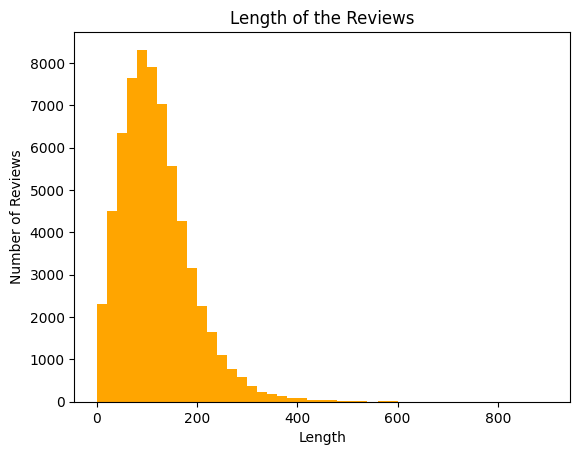

<Figure size 1200x800 with 0 Axes>

In [9]:
df['text_length'] = df['text'].str.len()
bin_size = 20
plt.hist(df['text_length'], bins=range(0, max(df['text_length']) + bin_size, bin_size), color='orange')
plt.title('Length of the Reviews')
plt.xlabel('Length')
plt.ylabel('Number of Reviews')
plt.figure(figsize=(12, 8))

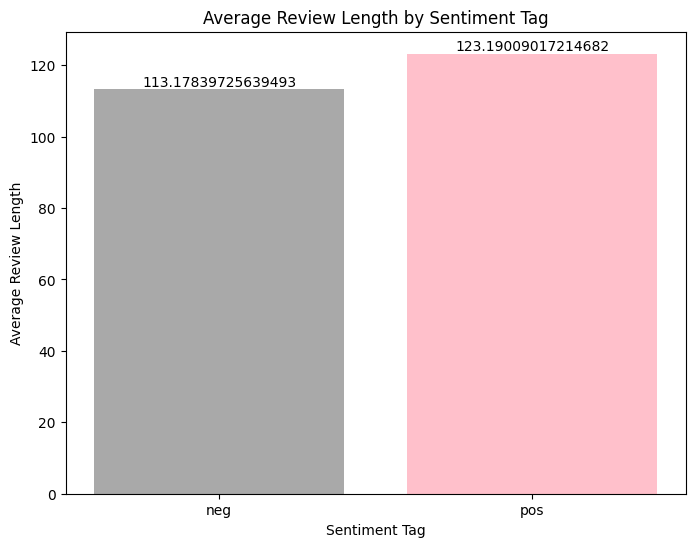

In [10]:
# group by sentiment_label and calculate average tweet length
grouped = df.groupby('tag')['text_length'].mean()

# create bar chart
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(grouped.index, grouped.values, color=['darkgrey', 'pink'])

# add data labels to the top of each column
for i, freq in enumerate(grouped):
    ax.text(i, freq, str(freq), ha='center', va='bottom')

# set axis labels and title
ax.set_xlabel('Sentiment Tag')
ax.set_ylabel('Average Review Length')
ax.set_title('Average Review Length by Sentiment Tag')

# show the plot
plt.show()

## PREPROCESSING

In [11]:
def preprocess_word(word):
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(text):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' EMO_POS ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    text = re.sub(r'(;-?\)|;-?D|\(-?;)|😉', ' EMO_POS ', text)
    # Sad -- :-(, : (, :(, ):, )-:
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', text)
    return text


def remove_emoji(text):
    return emoji.replace_emoji(text, replace=" ")


def preprocess_text(text):
    processed_text = []
    # Convert to lower case
    text = text.lower()
    
    #Clean only digits
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
    
    # Replaces URLs with the word URL
    #text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', text)
    text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', text)
    
    # Replace @handle with the word USER_MENTION
    #text = re.sub(r'@[\S]+', 'USER_MENTION', text)
    text = re.sub(r'@[\S]+', '', text)
    
    # Replaces #hashtag with hashtag
    #text = re.sub(r'#(\S+)', r' \1 ', text)
    text = re.sub(r'#(\S+)', '', text)
    
    # Remove RT (retext)
    text = re.sub(r'\brt\b', '', text)
    
    # Replace 2+ dots with space
    text = re.sub(r'\.{2,}', ' ', text)
    
    # Strip space, " and ' from text
    text = text.strip(' "\'')

    # remove special characters using regex
    text = re.sub(r'[^\w\s]', '', text)   

    # Replace emojis with either EMO_POS or EMO_NEG
    text = handle_emojis(text)

    #remove emojis
    text = remove_emoji(text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    words = text.split()

    for word in words:
        word = preprocess_word(word)
        processed_text.append(word)

    return ' '.join(processed_text)

In [12]:
df["processed_text"] = tqdm(df["text"].apply(preprocess_text))

100%|██████████| 64720/64720 [00:00<00:00, 2475224.13it/s]


In [13]:
df.head()

,fold_id,cv_tag,html_id,sent_id,text,tag,text_length,processed_text
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos,265,films adapted from comic books have had plenty...
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos,172,for starters it was created by alan moore and ...
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos,150,to say moore and campbell thoroughly researche...
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos,138,the book or graphic novel if you will is over ...
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos,64,in other words dont dismiss this film because ...


## REMOVING STOPWORDS

In [14]:
# set stopwords language
stop_words = set(stopwords.words('english'))

# define a function to remove stop words from a sentence
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# apply the remove_stopwords function to the 'text' column
df['processed_text_without_stopwords'] = df['processed_text'].apply(remove_stopwords)

# print the modified dataframe
df.head()

,fold_id,cv_tag,html_id,sent_id,text,tag,text_length,processed_text,processed_text_without_stopwords
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos,265,films adapted from comic books have had plenty...,films adapted comic books plenty success wheth...
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos,172,for starters it was created by alan moore and ...,starters created alan moore eddie campbell bro...
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos,150,to say moore and campbell thoroughly researche...,say moore campbell thoroughly researched subje...
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos,138,the book or graphic novel if you will is over ...,book graphic novel pages long includes nearly ...
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos,64,in other words dont dismiss this film because ...,words dont dismiss film source


In [15]:
df

,fold_id,cv_tag,html_id,sent_id,text,tag,text_length,processed_text,processed_text_without_stopwords
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos,265,films adapted from comic books have had plenty...,films adapted comic books plenty success wheth...
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos,172,for starters it was created by alan moore and ...,starters created alan moore eddie campbell bro...
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos,150,to say moore and campbell thoroughly researche...,say moore campbell thoroughly researched subje...
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos,138,the book or graphic novel if you will is over ...,book graphic novel pages long includes nearly ...
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos,64,in other words dont dismiss this film because ...,words dont dismiss film source
...,...,...,...,...,...,...,...,...,...
64715,9,cv999,14636,20,that lack of inspiration can be traced back to...,neg,82,that lack of inspiration can be traced back to...,lack inspiration traced back insipid characters
64716,9,cv999,14636,21,like too many of the skits on the current inca...,neg,241,like too many of the skits on the current inca...,like many skits current incarnation _saturday_...
64717,9,cv999,14636,22,"after watching one of the "" roxbury "" skits on...",neg,151,after watching one of the roxbury skits on snl...,watching one roxbury skits snl come away chara...
64718,9,cv999,14636,23,"bump unsuspecting women , and . . . that's all .",neg,48,bump unsuspecting women and thats all,bump unsuspecting women thats


In [16]:
def get_top_words(df, column_name, top_n=20):
    # get the list of tweets from the specified column
    tweets = df[column_name].astype(str).tolist()
    
    # tokenize all the words from the tweets
    words = []
    for tweet in tweets:
        words += word_tokenize(tweet.lower())  # convert to lowercase and tokenize the tweet

    # calculate the frequency distribution of words
    freq_dist = FreqDist(words)

    # return the top n most common words
    return freq_dist.most_common(top_n)

In [17]:
# create new data frames for each sentiment label
df_positive = df[df["tag"] == "pos"]
df_negative = df[df["tag"] == "neg"]

In [18]:
get_top_words(df, "processed_text_without_stopwords", 20)

[('film', 8858),
 ('one', 5520),
 ('movie', 5438),
 ('like', 3553),
 ('even', 2555),
 ('good', 2320),
 ('time', 2283),
 ('story', 2117),
 ('films', 2105),
 ('would', 2041),
 ('much', 2023),
 ('also', 1965),
 ('characters', 1947),
 ('get', 1921),
 ('character', 1906),
 ('two', 1824),
 ('first', 1768),
 ('see', 1730),
 ('well', 1695),
 ('way', 1668)]

In [19]:
# Positive sentiment without stopwords
get_top_words(df_positive, "processed_text_without_stopwords", 20)

[('film', 4864),
 ('one', 2904),
 ('movie', 2389),
 ('like', 1718),
 ('story', 1214),
 ('also', 1200),
 ('films', 1199),
 ('good', 1193),
 ('even', 1174),
 ('time', 1171),
 ('characters', 1038),
 ('much', 1026),
 ('character', 1013),
 ('would', 992),
 ('life', 982),
 ('well', 968),
 ('first', 963),
 ('two', 959),
 ('see', 954),
 ('way', 915)]

In [20]:
# Negative sentiment without stopwords
get_top_words(df_negative, "processed_text_without_stopwords", 20)

[('film', 3994),
 ('movie', 3049),
 ('one', 2616),
 ('like', 1835),
 ('even', 1381),
 ('good', 1127),
 ('time', 1112),
 ('would', 1049),
 ('get', 1037),
 ('bad', 1018),
 ('much', 997),
 ('characters', 909),
 ('films', 906),
 ('story', 903),
 ('character', 893),
 ('plot', 876),
 ('two', 865),
 ('make', 818),
 ('first', 805),
 ('really', 781)]

In [21]:
def plot_wordcloud(df, col):
    # Concatenate all text data in the specified column into a single string
    text = " ".join(i for i in df[col])
    text = " ".join(word for word in text.split() if word != "film")
    text = " ".join(word for word in text.split() if word != "movie")
    text = " ".join(word for word in text.split() if word != "character")
    text = " ".join(word for word in text.split() if word != "make")
    text = " ".join(word for word in text.split() if word != "one")
    text = " ".join(word for word in text.split() if word != "scene")
    text = " ".join(word for word in text.split() if word != "time")
    text = " ".join(word for word in text.split() if word != "story")
    text = " ".join(word for word in text.split() if word != "would")
    # Create a wordcloud object
    wc = WordCloud(background_color="black",
                   max_words=1000,
                   contour_width=3,
                   contour_color="firebrick",
                   width=800, height=400).generate(text)

    # Plot the wordcloud
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

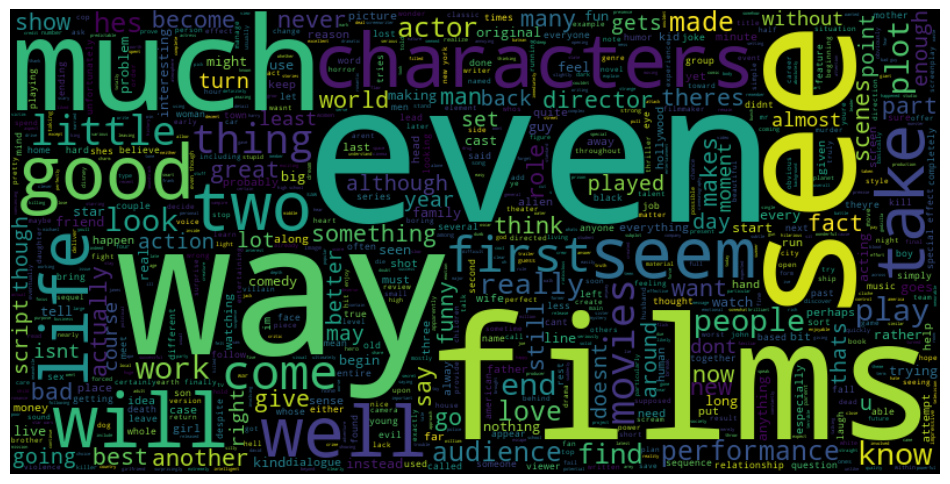

In [22]:
plot_wordcloud(df, "processed_text")

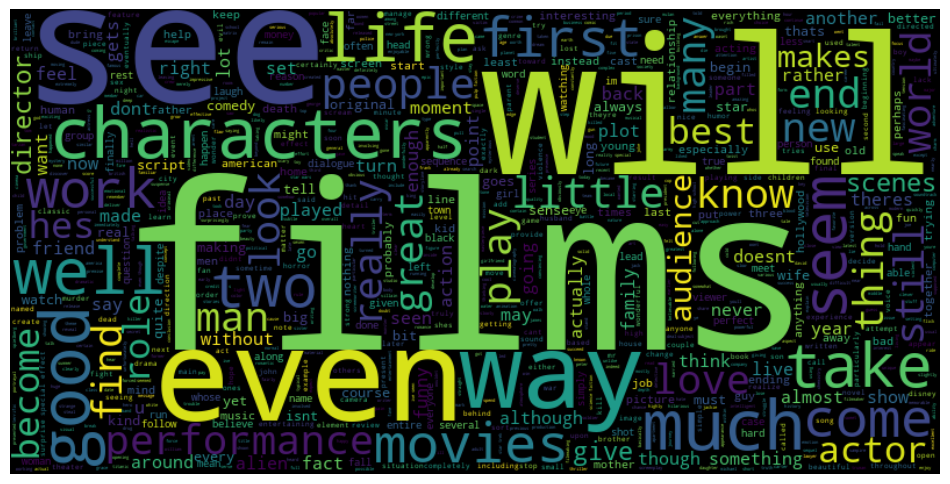

In [23]:
plot_wordcloud(df_positive, "processed_text")

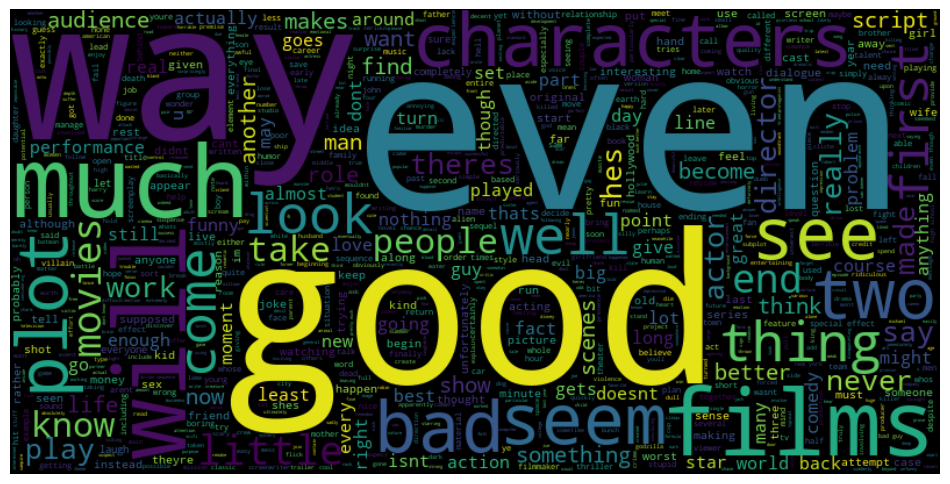

In [24]:
plot_wordcloud(df_negative, "processed_text")

In [25]:
df = df[['processed_text_without_stopwords', 'tag']]
df.head()

,processed_text_without_stopwords,tag
0,films adapted comic books plenty success wheth...,pos
1,starters created alan moore eddie campbell bro...,pos
2,say moore campbell thoroughly researched subje...,pos
3,book graphic novel pages long includes nearly ...,pos
4,words dont dismiss film source,pos


In [26]:
# transforming labels into a numerical representation for ML algorithms
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['tag'])
df = df.rename(columns={'processed_text_without_stopwords': 'clean_text'})
df.drop('tag', axis=1, inplace=True)
df.reset_index()
df.head()

,clean_text,label
0,films adapted comic books plenty success wheth...,1
1,starters created alan moore eddie campbell bro...,1
2,say moore campbell thoroughly researched subje...,1
3,book graphic novel pages long includes nearly ...,1
4,words dont dismiss film source,1


In [27]:
df['label'].value_counts()

1    32937
0    31783
Name: label, dtype: int64

In [28]:
print(df.isna().any()) 

clean_text    False
label         False
dtype: bool


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
train, test = train_test_split(df, test_size=0.3, random_state=42)

# print the shape of the resulting DataFrames
print('Training set shape:', train.shape)
print('Testing set shape:', test.shape)

Training set shape: (45304, 2)
Testing set shape: (19416, 2)


In [30]:
#train_plot = df[:5000]
#test_plot = df[5000:6000]
train_plot = train.iloc[np.random.choice(len(test), 5000)]
test_plot = test.iloc[np.random.choice(len(test), 1000)]

## BERT MODEL

In [31]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

# BERT model without hyperparameters
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
model_plot = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

# BERT model with hyperparameters
model_hyper = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
model_hyper_plot = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model 

In [32]:
def convert_data_to_examples(train, test, clean_text, label): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[clean_text], 
                                                          label = x[label]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[clean_text], 
                                                          label = x[label]), axis = 1,)
  
    return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train,  test, 'clean_text',  'label')
train_InputExamples_plot, validation_InputExamples_plot = convert_data_to_examples(train_plot,  test_plot, 'clean_text',  'label')

In [33]:
train_InputExamples

42271    InputExample(guid=None, text_a='even intellect...
17965    InputExample(guid=None, text_a='together young...
34526    InputExample(guid=None, text_a='songs alright ...
21093    InputExample(guid=None, text_a='things change ...
3884     InputExample(guid=None, text_a='real murderers...
                               ...                        
62570    InputExample(guid=None, text_a='laughable mome...
38158    InputExample(guid=None, text_a='even aspect fi...
860      InputExample(guid=None, text_a='schreber conta...
15795    InputExample(guid=None, text_a='sure excellent...
56422    InputExample(guid=None, text_a='dismal thirdra...
Length: 45304, dtype: object

In [34]:
train_InputExamples_plot


23614    InputExample(guid=None, text_a='film opens hou...
43317    InputExample(guid=None, text_a='half hour go s...
16019    InputExample(guid=None, text_a='performance co...
39297    InputExample(guid=None, text_a='work wire assi...
9702     InputExample(guid=None, text_a='much films bea...
                               ...                        
45983    InputExample(guid=None, text_a='sinise wonderf...
19849    InputExample(guid=None, text_a='big picture mo...
188      InputExample(guid=None, text_a='norton one per...
21340    InputExample(guid=None, text_a='undo must live...
37776    InputExample(guid=None, text_a='accurate summa...
Length: 5000, dtype: object

In [35]:
validation_InputExamples

58154    InputExample(guid=None, text_a='like dream wit...
33401    InputExample(guid=None, text_a='stateoftheart ...
44182    InputExample(guid=None, text_a='action films a...
46480    InputExample(guid=None, text_a='number reasons...
41584    InputExample(guid=None, text_a='julie james je...
                               ...                        
18484    InputExample(guid=None, text_a='many bigbudget...
35705    InputExample(guid=None, text_a='obviously wasn...
5181     InputExample(guid=None, text_a='tension dissip...
41717    InputExample(guid=None, text_a='ever sat antic...
16707    InputExample(guid=None, text_a='walking theate...
Length: 19416, dtype: object

In [36]:
validation_InputExamples_plot

45815    InputExample(guid=None, text_a='central charac...
36937    InputExample(guid=None, text_a='related aside ...
25228    InputExample(guid=None, text_a='fans familiar ...
1423     InputExample(guid=None, text_a='film begins sh...
64450    InputExample(guid=None, text_a='movie really s...
                               ...                        
46712    InputExample(guid=None, text_a='twohour still ...
62630    InputExample(guid=None, text_a='story contrive...
29155    InputExample(guid=None, text_a='blurry slow mo...
29646    InputExample(guid=None, text_a='nothing like m...
60117    InputExample(guid=None, text_a='also sexcrazed...
Length: 1000, dtype: object

In [37]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in tqdm(examples):
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,    # Add 'CLS' and 'SEP'
            max_length=max_length,    # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],input_dict["token_type_ids"], input_dict['attention_mask'])
        features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label) )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [38]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

100%|██████████| 45304/45304 [00:20<00:00, 2157.56it/s]


In [39]:
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

100%|██████████| 19416/19416 [00:09<00:00, 2120.67it/s]


In [40]:
# model without hyperparameters (full data)

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
)

history = model.fit(train_data, epochs=1, validation_data=validation_data)

2832/2832 [==============================] - 1482s 508ms/step - loss: 0.6975 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.4922


In [44]:
# model with hyperparameters (full data)

model_hyper.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
)

history = model_hyper.fit(train_data, epochs=1, validation_data=validation_data)

2832/2832 [==============================] - 1550s 531ms/step - loss: 0.1751 - accuracy: 0.9284 - val_loss: 0.9261 - val_accuracy: 0.7011


In [46]:
train_data_plot = convert_examples_to_tf_dataset(list(train_InputExamples_plot), tokenizer)
train_data_plot = train_data_plot.shuffle(100).batch(32).repeat(2)

100%|██████████| 5000/5000 [00:02<00:00, 2186.45it/s]


In [47]:
validation_data_plot = convert_examples_to_tf_dataset(list(validation_InputExamples_plot), tokenizer)
validation_data_plot = validation_data_plot.batch(32)

100%|██████████| 1000/1000 [00:00<00:00, 2166.02it/s]


In [48]:
# model_plot for model without hyperparameters (reduced dataset)
from tensorflow.keras.callbacks import EarlyStopping

model_plot.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
# define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history_plot = model_plot.fit(train_data_plot, epochs=10, validation_data=validation_data_plot,callbacks=[early_stop])

Epoch 1/10
314/314 [==============================] - 196s 497ms/step - loss: 0.7097 - accuracy: 0.5061 - val_loss: 0.6949 - val_accuracy: 0.5100
Epoch 2/10
314/314 [==============================] - 154s 489ms/step - loss: 0.6975 - accuracy: 0.5096 - val_loss: 0.6983 - val_accuracy: 0.5100
Epoch 3/10
314/314 [==============================] - 154s 490ms/step - loss: 0.6973 - accuracy: 0.5126 - val_loss: 0.6939 - val_accuracy: 0.4900
Epoch 4/10
314/314 [==============================] - 155s 493ms/step - loss: 0.6959 - accuracy: 0.5101 - val_loss: 0.6977 - val_accuracy: 0.5100
Epoch 5/10
314/314 [==============================] - 155s 492ms/step - loss: 0.6951 - accuracy: 0.5022 - val_loss: 0.6936 - val_accuracy: 0.5100
Epoch 6/10
314/314 [==============================] - 155s 493ms/step - loss: 0.6949 - accuracy: 0.5043 - val_loss: 0.6936 - val_accuracy: 0.4900
Epoch 7/10
314/314 [==============================] - 154s 492ms/step - loss: 0.6947 - accuracy: 0.5055 - val_loss: 0.6934 -

In [ ]:
# model_hyper_plot for model with hyperparameters (reduced dataset)
from tensorflow.keras.callbacks import EarlyStopping

model_hyper_plot.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
# define early stoppingc
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history_hyper_plot = model_hyper_plot.fit(train_data_plot, epochs=10, validation_data=validation_data_plot,callbacks=[early_stop])

Epoch 1/10
314/314 [==============================] - 214s 531ms/step - loss: 0.6106 - accuracy: 0.6434 - val_loss: 0.6571 - val_accuracy: 0.6760
Epoch 2/10
314/314 [==============================] - 158s 503ms/step - loss: 0.2033 - accuracy: 0.9227 - val_loss: 1.1432 - val_accuracy: 0.6550
Epoch 3/10
201/314 [==================>...........] - ETA: 54s - loss: 0.0725 - accuracy: 0.9752

In [ ]:
# movie reviews for testing
pred_sentences = ['This film falls short on many levels, offering a lackluster and forgettable viewing experience. The story is poorly developed, with little depth or nuance to keep viewers engaged. The lead performances are uninspired, with the actors failing to bring any real emotion or depth to their characters. The direction is lackadaisical, with the pacing dragging on and the film lacking any real visual flair. The cinematography is unremarkable, failing to capture any sense of mood or atmosphere. The score is forgettable, offering little to enhance the viewing experience. Overall, this film is a disappointment, failing to deliver on any real level and ultimately feeling like a wasted opportunity.','bad','This film is a cinematic masterpiece that takes viewers on a breathtaking journey through the human experience. The story is both poignant and powerful, exploring complex themes of love, loss, and redemption. The lead performances are outstanding, with the actors bringing a raw and emotional depth to their characters. The direction is masterful, with every shot carefully crafted to capture the essence of the story. The cinematography is stunning, immersing viewers in a rich and vibrant world that feels both familiar and otherworldly. The score is hauntingly beautiful, adding an extra layer of depth to the already powerful narrative. This film is a must-see for anyone who appreciates great storytelling and exceptional filmmaking.','flawless', 'This movie is a tedious and forgettable experience. The plot is poorly developed, the acting is uninspired, and the direction lacks any real vision or creativity.']

In [ ]:
# testing on model without hyperparameters 

# full data
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model 
tf_outputs = model(tf_batch)                                  

tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", labels[label[i]])

In [ ]:
# IS THIS RIGHT?
# reduced data
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model 
tf_outputs = model_plot(tf_batch)                                  

tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", labels[label[i]])

In [ ]:
# testing on model with hyperparameters

# full data 
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model  
tf_outputs = model_hyper(tf_batch)                                  

tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", labels[label[i]])

In [ ]:
# IS THIS RIGHT?
# reduced data
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model 
tf_outputs = model_hyper_plot(tf_batch)                                  

tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", labels[label[i]])

In [ ]:
history_dict = history_plot.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(5, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (Without Hyper parameter tuning)')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (Without Hyper parameter tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
history_dict = history_hyper_plot.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(5, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (With Hyper parameter tuning)')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (With Hyper parameter tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')